In [1]:
#|export
from tsai.imports import *
from tsai.models.layers import *
from torchinfo import summary

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
# from tqdm.notebook import tqdm

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# hyper parameter
num_classes = 30
close_num = 14 # 14, 19, 24, 29
batch_size = 64
learning_rate = 0.0001
num_epochs = 300
down_ratio = 8
sequence_len = 2000 * 5 // down_ratio # default 2000Hz
overlap = int(sequence_len * 0.3)
threshold = 0.8
thresholds = [0.3, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80]
close_nums = [14, 19, 24, 29]
alpha = 0.1

In [5]:
radar_frame_list = []
scaler = MinMaxScaler((-1, 1)) # or StandardScaler

for i in range(1, num_classes + 1):
    # wave_2d = [] # input need to be 2d?
    file_path = "./data/radar_%02d.csv" % i # or ./data/radar_%02d
    radar_frame = pd.read_csv(file_path)
    wave = radar_frame.to_numpy().flatten()
    wave = signal.decimate(wave, down_ratio) # down sampling
    
    end = len(wave)
    n = 0
    n_stop = sequence_len
    wave_segments = []

    while n_stop < end:
        n_start = 0 + ((sequence_len - 1) - (overlap - 1)) * n
        n_stop = n_start + sequence_len
        tmp = []
        seg = wave[n_start:n_stop].copy()
        wave_segments.append([seg])
        n += 1
    
    radar_frame_list.append(wave_segments)

data_df = pd.DataFrame(radar_frame_list)

In [50]:
labels = []
for i in range(len(radar_frame_list)):
    for j in range(len(radar_frame_list[i])):
        if i <= close_num:
            labels.append(i)
        else:
            labels.append(close_num + 1)

labels_series = pd.Series(labels)

In [7]:
tmp = data_df.to_numpy().flatten().copy()
data_series = pd.Series(tmp).dropna() # remove None (keys are as they are)
tmp = data_series.to_numpy().flatten()

tmp_labels = labels_series.to_numpy().flatten()
# len(tmp) = 5442 (30人分のデータ)
# len(tmp[0]) = 1 (in_channelが1のため)
# len(tmp[0][0]) = 1250 (sequence_len)

for i in reversed(range(len(tmp))):
  if len(tmp[i][0]) != sequence_len:
    print(i, len(tmp[i][0]))
    tmp = np.delete(tmp, i)
    tmp_labels = np.delete(tmp_labels, i)

data_series = pd.Series(tmp)
labels_series = pd.Series(tmp_labels)
labels_tensor = torch.tensor(labels_series)
data_series.shape, labels_tensor, labels_tensor.shape

5441 900
5262 838
5086 725
4911 1219
4732 507
4497 1107
4321 1244
4147 838
3953 438
3764 1232
3589 788
3406 1150
3234 619
3052 1188
2880 388
2705 1113
2348 1157
2141 1113
1956 1232
1771 532
1588 475
1402 644
1225 1232
1044 482
869 1150
695 1144
523 713
351 713
173 525


((5413,), tensor([ 0,  0,  0,  ..., 15, 15, 15]), torch.Size([5413]))

In [8]:
class InceptionModule(Module):
    def __init__(self, ni, nf, ks=40, bottleneck=True):
        ks = [ks // (2**i) for i in range(3)]
        ks = [k if k % 2 != 0 else k - 1 for k in ks]  # ensure odd ks
        bottleneck = bottleneck if ni > 1 else False
        self.bottleneck = Conv1d(ni, nf, 1, bias=False) if bottleneck else noop
        self.convs = nn.ModuleList([Conv1d(nf if bottleneck else ni, nf, k, bias=False) for k in ks])
        self.maxconvpool = nn.Sequential(*[nn.MaxPool1d(3, stride=1, padding=1), Conv1d(ni, nf, 1, bias=False)])
        self.concat = Concat()
        self.bn = BN1d(nf * 4)
        self.act = nn.ReLU()

    def forward(self, x):
        input_tensor = x
        x = self.bottleneck(input_tensor)
        x = self.concat([l(x) for l in self.convs] + [self.maxconvpool(input_tensor)])
        return self.act(self.bn(x))


@delegates(InceptionModule.__init__)
class InceptionBlock(Module):
    def __init__(self, ni, nf=32, residual=True, depth=6, **kwargs):
        self.residual, self.depth = residual, depth
        self.inception, self.shortcut = nn.ModuleList(), nn.ModuleList()
        for d in range(depth):
            self.inception.append(InceptionModule(ni if d == 0 else nf * 4, nf, **kwargs))
            if self.residual and d % 3 == 2: 
                n_in, n_out = ni if d == 2 else nf * 4, nf * 4
                self.shortcut.append(BN1d(n_in) if n_in == n_out else ConvBlock(n_in, n_out, 1, act=None))
        self.add = Add()
        self.act = nn.ReLU()
        
    def forward(self, x):
        res = x
        for d, l in enumerate(range(self.depth)):
            x = self.inception[d](x)
            if self.residual and d % 3 == 2: res = x = self.act(self.add(x, self.shortcut[d//3](res)))
        return x

    
@delegates(InceptionModule.__init__)
class InceptionTime(Module):
    def __init__(self, c_in, c_out, seq_len=None, nf=32, nb_filters=None, **kwargs):
        nf = ifnone(nf, nb_filters) # for compatibility
        self.inceptionblock = InceptionBlock(c_in, nf, **kwargs) # c_in is input channel num of conv1d
        self.gap = GAP1d(1)
        self.fc = nn.Linear(nf * 4, c_out) # c_out is 1d output size 

    def forward(self, x):
        x = self.inceptionblock(x)
        x = self.gap(x)
        x = self.fc(x)
        return x

In [9]:
class MyDataset(Dataset):
    def __init__(self, dataset, labels, root_dir, transform=None) -> None:
        # super().__init__()
        self.radar_heartbeat = dataset
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()
        
        onehot_label = torch.eye(num_classes)[self.labels[idx] - 1] # one hot encodingは不要らしい　精度悪い場合試す必要あり
        # one_hot = torch.nn.functional.one_hot(self.labels, num_classes=num_classes)
        return torch.tensor(self.radar_heartbeat[idx]), self.labels[idx] # labels is already tensor (converted in preparation phase)
        # return torch.tensor(self.radar_heartbeat[idx]), onehot_label

    def __len__(self):
        return len(self.radar_heartbeat)


dataset = MyDataset(data_series, labels_tensor, "./data/", transform=transforms.ToTensor())

In [11]:
dataset[0][1], dataset[4473][1], dataset[4474][1], dataset[len(dataset)-1][1]

/tmp/ipykernel_31087/3033810394.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.tensor(self.radar_heartbeat[idx]), self.labels[idx] # labels is already tensor (converted in preparation phase)


(tensor(0), tensor(15), tensor(15), tensor(15))

In [12]:
dataset[3570][1], dataset[3571][1]

(tensor(15), tensor(15))

In [13]:
dataset[2691][1], dataset[2692][1]

(tensor(14), tensor(15))

Additional processing for Open Set

e.g.
train 0~24

test 0~30

concat

In [ ]:
# indices1 = np.arange(4473)
# dataset1 = torch.utils.data.Subset(dataset, indices1) # 0-24
# indices2 = np.arange(4474, len(dataset))
# dataset2 = torch.utils.data.Subset(dataset, indices2) # 25-30
# Unknown_label = close_num + 1

In [ ]:
# indices1 = np.arange(3570)
# dataset1 = torch.utils.data.Subset(dataset, indices1) # 0-19
# indices2 = np.arange(3571, len(dataset))
# dataset2 = torch.utils.data.Subset(dataset, indices2) # 20-30
# Unknown_label = close_num + 1

In [10]:
indices1 = np.arange(2691)
dataset1 = torch.utils.data.Subset(dataset, indices1) # 0-14
indices2 = np.arange(2692, len(dataset))
dataset2 = torch.utils.data.Subset(dataset, indices2) # 15-29
Unknown_label = close_num + 1

In [11]:
train_size1 = int(0.80 * len(dataset1))
test_size1 = len(dataset1) - train_size1

train_size2 = int(0.80 * len(dataset2))
test_size2 = len(dataset2) - train_size2

open_train_set, test_set1 = torch.utils.data.random_split(dataset1, [train_size1, test_size1])
train_set2, test_set2 = torch.utils.data.random_split(dataset2, [train_size2, test_size2])

indices = np.arange(len(test_set2))
test_set2 = torch.utils.data.Subset(test_set2, indices[:])

train : test = 8 : 2 → 3 : 1で分ける

In [12]:
open_test_set = torch.utils.data.ConcatDataset([test_set1, test_set2])
len(open_train_set), len(open_test_set)

(2152, 1084)

In [13]:
train_size = int(0.80 * len(data_series.values))
test_size = len(data_series.values) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size]) # check whether each data and label set is synchronized 
# print(f"full: {len(dataset)} -> train: {len(train_set)}, test: {len(test_set)}")

train_loader = DataLoader(dataset=open_train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=open_test_set, batch_size=batch_size, shuffle=True) # テストでシャッフルしても同じ

## Triple Joint Loss

In [15]:
from torch import log
softmax = nn.Softmax()

def softmax_loss(outputs, labels):
    loss = 0
    batch_size = len(labels)
    softmax_out = softmax(outputs)
    for idx in range(batch_size):
        loss += 1.0 - log(softmax_out[labels[idx]])
    return loss / batch_size


from center_loss import CenterLoss
center_loss = CenterLoss(num_classes=close_num + 1, feat_dim=1, use_gpu=True)
optimizer_centloss = torch.optim.SGD(center_loss.parameters(), lr=0.05)


class AngularPenaltySMLoss(nn.Module):

    def __init__(self, in_features, out_features, loss_type='cosface', eps=1e-7, s=None, m=None):
        '''
        Angular Penalty Softmax Loss
        Three 'loss_types' available: ['arcface', 'sphereface', 'cosface']
        These losses are described in the following papers: 
        
        ArcFace: https://arxiv.org/abs/1801.07698
        SphereFace: https://arxiv.org/abs/1704.08063
        CosFace/Ad Margin: https://arxiv.org/abs/1801.05599
        '''
        super(AngularPenaltySMLoss, self).__init__()
        loss_type = loss_type.lower()
        assert loss_type in  ['arcface', 'sphereface', 'cosface']
        if loss_type == 'arcface':
            self.s = 64.0 if not s else s
            self.m = 0.5 if not m else m
        if loss_type == 'sphereface':
            self.s = 64.0 if not s else s
            self.m = 1.35 if not m else m
        if loss_type == 'cosface':
            self.s = 30.0 if not s else s
            self.m = 0.45 if not m else m
        self.loss_type = loss_type
        self.in_features = in_features
        self.out_features = out_features
        self.fc = nn.Linear(in_features, out_features, bias=False)
        self.eps = eps

    def forward(self, x, labels):
        '''
        input shape (N, in_features)
        '''
        assert len(x) == len(labels)
        assert torch.min(labels) >= 0
        assert torch.max(labels) < self.out_features
        
        for W in self.fc.parameters():
            W = F.normalize(W, p=2, dim=1)

        x = F.normalize(x, p=2, dim=1)

        wf = self.fc(x)
        if self.loss_type == 'cosface':
            numerator = self.s * (torch.diagonal(wf.transpose(0, 1)[labels]) - self.m)
        if self.loss_type == 'arcface':
            numerator = self.s * torch.cos(torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)) + self.m)
        if self.loss_type == 'sphereface':
            numerator = self.s * torch.cos(self.m * torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)))

        excl = torch.cat([torch.cat((wf[i, :y], wf[i, y+1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s * excl), dim=1)
        L = numerator - torch.log(denominator)
        return -torch.mean(L)

cos_loss = AngularPenaltySMLoss(1, close_num + 1, loss_type="cosface")


def triple_joint_loss(output, label, alpha):
    # alpha: hyper parameter
    output_for_cent = []
    for idx, x in enumerate(output):
        x = x[label[idx]]
        x = torch.tensor(x).to(device)
        output_for_cent.append([x])
    output_for_cent = torch.tensor(output_for_cent)
    output_for_cent = output_for_cent.float()
    output_for_cent = output_for_cent.to(device)
    return softmax_loss(output, label) + alpha * center_loss(output_for_cent, label)

In [16]:
model = InceptionTime(1, close_num + 1) # 0-?+Unknownを出力
model = model.to(device)
# criterion = nn.CrossEntropyLoss() # TJL使うときはコメントアウト
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
summary(model)

Layer (type:depth-idx)                        Param #
InceptionTime                                 --
├─InceptionBlock: 1-1                         --
│    └─ModuleList: 2-1                        --
│    │    └─InceptionModule: 3-1              2,432
│    │    └─InceptionModule: 3-2              77,056
│    │    └─InceptionModule: 3-3              77,056
│    │    └─InceptionModule: 3-4              77,056
│    │    └─InceptionModule: 3-5              77,056
│    │    └─InceptionModule: 3-6              77,056
│    └─ModuleList: 2-2                        --
│    │    └─ConvBlock: 3-7                    384
│    │    └─BatchNorm1d: 3-8                  256
│    └─Add: 2-3                               --
│    └─ReLU: 2-4                              --
├─GAP1d: 1-2                                  --
│    └─AdaptiveAvgPool1d: 2-5                 --
│    └─Flatten: 2-6                           --
├─Linear: 1-3                                 1,935
Total params: 390,287
Trainable para

In [30]:
# torch.set_default_tensor_type('torch.cuda.FloatTensor')
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (signals, labels) in enumerate(train_loader):
    signals = torch.tensor(signals)
    signals = signals.float()
    signals = signals.to(device)
    labels = labels.to(device)

    # print(signals.size())
    outputs = model(signals)
    # print(outputs)
    loss = triple_joint_loss(outputs, labels, alpha) # will check the shapes of outputs and labels
    

    loss = center_loss(output_for_cent, labels)

    optimizer.zero_grad()
    optimizer_centloss.zero_grad()
    loss.backward()
    optimizer.step()
    optimizer_centloss.step()
    if (i + 1) % 12 == 0:
      print(f'Epoch [{epoch+1}/`{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

/tmp/ipykernel_22252/1573358285.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_22252/1573358285.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/center_loss.py:45: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  distmat.addmm_(1, -2, x, self.centers.t())


Epoch [1/`20], Step [12/34], Loss: 0.8664
Epoch [1/`20], Step [24/34], Loss: 0.7056
Epoch [2/`20], Step [12/34], Loss: 0.6349
Epoch [2/`20], Step [24/34], Loss: 0.3538
Epoch [3/`20], Step [12/34], Loss: 0.3928
Epoch [3/`20], Step [24/34], Loss: 0.2485
Epoch [4/`20], Step [12/34], Loss: 0.2200
Epoch [4/`20], Step [24/34], Loss: 0.2082
Epoch [5/`20], Step [12/34], Loss: 0.1202
Epoch [5/`20], Step [24/34], Loss: 0.1365
Epoch [6/`20], Step [12/34], Loss: 0.1034
Epoch [6/`20], Step [24/34], Loss: 0.0619
Epoch [7/`20], Step [12/34], Loss: 0.0591
Epoch [7/`20], Step [24/34], Loss: 0.0536
Epoch [8/`20], Step [12/34], Loss: 0.0448
Epoch [8/`20], Step [24/34], Loss: 0.0444
Epoch [9/`20], Step [12/34], Loss: 0.0336
Epoch [9/`20], Step [24/34], Loss: 0.0283
Epoch [10/`20], Step [12/34], Loss: 0.0175
Epoch [10/`20], Step [24/34], Loss: 0.0192
Epoch [11/`20], Step [12/34], Loss: 0.0298
Epoch [11/`20], Step [24/34], Loss: 0.0177
Epoch [12/`20], Step [12/34], Loss: 0.0136
Epoch [12/`20], Step [24/34],

labelは0-24までだから，学習はいじらなくて大丈夫

testはOpen setの場合，0~24とUnknown label(25)になるから，labelは作り直し

25も出力するようなネットワークにしなきゃだめ

In [ ]:
outputs

In [31]:
# For Confusion Matrix
predicted_lists = np.zeros(0, dtype=np.int64)
one_hot_labels_list = np.zeros(0, dtype=np.int64)

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  softmax = nn.Softmax()
  for i, (signals, one_hot_labels) in enumerate(test_loader):
    signals = torch.tensor(signals)
    signals = signals.float()
    signals = signals.to(device)
    one_hot_labels = one_hot_labels.to(device)
    # print(len(one_hot_labels))
    outputs = model(signals)
    for j, out in enumerate(outputs):
      outputs[j] = softmax(out)

    _, predicted = torch.max(outputs.data, 1) # predicted per batch size
    
    
    for idx in range(len(_)):
      if _[idx] < threshold:
        predicted[idx] = Unknown_label # 15, 20, 25
    print(_, predicted, one_hot_labels)

    n_samples += one_hot_labels.size(0) # add batch_size
    n_correct += (predicted == one_hot_labels).sum().item()
    
    predicted_cp = predicted.to('cpu').detach().numpy().copy()
    one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
    predicted_lists = np.concatenate([predicted_lists, predicted_cp])
    one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
    
    acc = 100.0 * n_correct / n_samples
    print(f'{n_correct} / {n_samples} = Acc: {acc} %')

/tmp/ipykernel_22252/1821349815.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)


TensorBase([0.1256, 0.1308, 0.1252, 0.1031, 0.1097, 0.1097, 0.1138, 0.1134,
            0.1231, 0.1182, 0.1043, 0.1081, 0.1097, 0.1133, 0.1187, 0.1106,
            0.1115, 0.1222, 0.1147, 0.1229, 0.1022, 0.1225, 0.1041, 0.1236,
            0.1081, 0.1107, 0.1022, 0.1106, 0.1123, 0.1151, 0.1319, 0.1289,
            0.1117, 0.1085, 0.1071, 0.1151, 0.1047, 0.1180, 0.1184, 0.1054,
            0.1211, 0.1038, 0.1067, 0.1265, 0.1181, 0.1152, 0.1081, 0.1160,
            0.1031, 0.1174, 0.1242, 0.1126, 0.1069, 0.1179, 0.1055, 0.1158,
            0.1197, 0.1303, 0.1095, 0.1149, 0.1319, 0.1177, 0.1242, 0.1098],
           device='cuda:0') TensorBase([15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
            15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
            15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
            15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
           device='cuda:0') tensor([15, 15, 15,  6, 15, 15

In [ ]:
predicted_lists[700:], one_hot_labels_list[700:]

In [ ]:
_

In [1012]:
output_for_cent = []
for idx, x in enumerate(outputs):
    x = x[labels[idx]]
    output_for_cent.append([x])
output_for_cent = torch.tensor(output_for_cent)
output_for_cent.shape

torch.Size([64, 1])

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(one_hot_labels_list, predicted_lists)
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("Ground Truth", fontsize=13)
fig_name = "sklearn_confusion_matrix_{}_{}.png".format(Unknown_label, threshold)
plt.savefig("./figure/" + fig_name)
cm

In [ ]:
x = np.linspace(0.30, 0.80, 11)
y1 = [86.33, 88.00, 89.94, 91.32, 92.70, 93.26, 93.81, 94.45, 94.92, 94.55, 93.63]
y2 = [71.01, 73.68, 76.55, 78.85, 82.83, 84.03, 85.78, 87.07, 87.72, 88.64, 88.27]
y3 = [55.44, 59.79, 64.76, 70.85, 75.37, 78.41, 80.72, 82.84, 86.25, 87.73, 89.30]
y0 = [99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08]
plt.ylim(55, 100)
plt.xlabel("Threshold")
plt.ylabel("Accuracy [%]")
plt.plot(x, y0, label="Openness=0, (threshold=0)")
plt.plot(x, y1, marker="o", label="Openness=0.087")
plt.plot(x, y2, marker="*", label="Openness=0.184")
plt.plot(x, y3, marker="x", label="Openness=0.293")
plt.legend()

In [ ]:
x = np.linspace(0.30, 0.80, 11)
y1 = []
y2 = [71.01, 73.68, 76.55, 78.85, 82.83, 84.03, 85.78, 87.07, 87.72, 88.64, 88.27]
y3 = [55.44, 59.79, 64.76, 70.85, 75.37, 78.41, 80.72, 82.84, 86.25, 87.73, 89.30]
y0 = [99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08]
plt.ylim(55, 100)
plt.xlabel("Threshold")
plt.ylabel("Accuracy [%]")
plt.plot(x, y0, label="Openness=0, (threshold=0)")
plt.plot(x, y1, marker="o", label="Openness=0.087")
plt.plot(x, y2, marker="*", label="Openness=0.184")
plt.plot(x, y3, marker="x", label="Openness=0.293")
plt.legend()

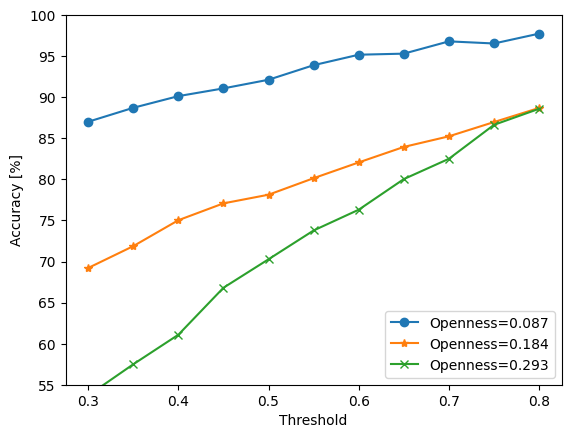

In [910]:
a = np.array([55.35055350553505, 61.99261992619926, 64.11439114391143, 70.75645756457564, 74.6309963099631, 73.5239852398524, 77.58302583025831, 84.5940959409594, 81.91881918819188, 90.59040590405904, 88.46863468634686])
b = np.array([55.71955719557196, 57.564575645756456, 61.62361623616236, 70.9409594095941, 71.58671586715867, 76.56826568265683, 75.27675276752767, 76.19926199261992, 81.2730627306273, 84.96309963099631, 88.00738007380073])
c = np.array([51.93726937269373, 54.7970479704797, 58.025830258302584, 62.08487084870849, 66.32841328413284, 71.03321033210332, 74.72324723247233, 78.50553505535055, 81.91881918819188, 84.77859778597787, 87.82287822878229])
d = np.array([52.859778597785976, 56.91881918819188, 61.254612546125465, 66.14391143911439, 70.84870848708488, 75.46125461254613, 78.87453874538745, 82.10332103321034, 85.05535055350553, 87.63837638376384, 90.59040590405904])
e = np.array([52.5830258302583, 56.18081180811808, 60.42435424354244, 64.11439114391143, 67.98892988929889, 72.32472324723247, 75.09225092250922, 78.78228782287823, 82.380073800738, 85.23985239852398, 88.09963099630997])
ave14 = np.mean([a, b, c, d, e], axis=0)

a1 = np.array([68.88273314866113, 73.40720221606648, 77.65466297322253, 78.67036011080333, 78.76269621421976, 84.57987072945522, 83.28716528162512, 87.44228993536473, 85.96491228070175, 88.9196675900277, 88.73499538319483])
b1 = np.array([69.3444136657433, 71.46814404432133, 76.08494921514313, 78.02400738688827, 78.30101569713759, 76.5466297322253, 83.10249307479225, 83.28716528162512, 87.07294552169898, 87.6269621421976, 90.2123730378578])
c1 = np.array([69.43674976915975, 71.83748845798708, 74.33056325023084, 76.36195752539243, 78.20867959372114, 81.4404432132964, 83.10249307479225, 85.68790397045245, 86.79593721144968, 89.10433979686057, 91.68975069252078])
d1 = np.array([68.69806094182826, 70.3601108033241, 72.11449676823638, 74.42289935364728, 75.53093259464451, 76.73130193905817, 78.02400738688827, 78.76269621421976, 80.33240997229917, 81.80978762696215, 84.11819021237304])
e1 = np.array([69.71375807940905, 72.29916897506925, 74.9769159741459, 77.93167128347184, 79.87072945521699, 81.4404432132964, 82.82548476454294, 84.57987072945522, 86.0572483841182, 87.44228993536473, 88.73499538319483])

ave19 = np.mean([a1, b1, c1, d1, e1], axis=0)

a2 = np.array([88.36565096952909, 91.87442289935365, 91.59741458910435, 93.62880886426593, 92.89012003693445, 93.90581717451524, 96.67590027700831, 95.10618651892891, 98.33795013850416, 95.38319482917821, 97.78393351800554])
b2 = np.array([87.90397045244691, 88.82733148661127, 91.59741458910435, 88.6426592797784, 91.2280701754386, 94.73684210526316, 94.73684210526316, 93.72114496768236, 95.93721144967682, 95.66020313942752, 97.04524469067405])
c2 = np.array([85.87257617728532, 87.53462603878117, 89.47368421052632, 91.59741458910435, 92.05909510618652, 93.25946445060019, 93.8134810710988, 95.01385041551247, 95.8448753462604, 96.67590027700831, 97.96860572483841])
d2 = np.array([86.88827331486611, 88.18097876269621, 89.38134810710989, 90.39704524469067, 91.5050784856879, 92.89012003693445, 94.45983379501385, 95.29085872576178, 96.02954755309327, 96.86057248384118, 97.4145891043398])
e2 = np.array([86.0572483841182, 87.16528162511543, 88.6426592797784, 91.13573407202216, 92.98245614035088, 94.73684210526316, 96.21421975992614, 97.4145891043398, 97.87626962142198, 98.15327793167128, 98.52262234533703])

ave24 = np.mean([a2, b2, c2, d2, e2], axis=0)

x = np.linspace(0.30, 0.80, 11)
y1 = ave14
y2 = ave19
y3 = ave24
y0 = [99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08]
plt.ylim(55, 100)
plt.xlabel("Threshold")
plt.ylabel("Accuracy [%]")
# plt.plot(x, y0, label="Openness=0, (threshold=0)")
plt.plot(x, y3, marker="o", label="Openness=0.087")
plt.plot(x, y2, marker="*", label="Openness=0.184")
plt.plot(x, y1, marker="x", label="Openness=0.293")
plt.legend()

最後のfc層の重みとバイアスを使用する
損失関数

In [ ]:
model.fc.weight, model.fc.bias

In [ ]:
outputs[0], labels

In [19]:
from math import log
softmax = nn.Softmax()

def softmax_loss(outputs, labels):
    loss = 0
    batch_size = len(labels)
    softmax_out = softmax(outputs)
    for idx in range(batch_size):
        loss += 1.0 - log(softmax_out[labels[idx]])
    return loss / batch_size


from center_loss import CenterLoss
center_loss = CenterLoss(num_classes=close_num + 1, feat_dim=1, use_gpu=True)
optimizer_centloss = torch.optim.SGD(center_loss.parameters(), lr=0.5)


class AngularPenaltySMLoss(nn.Module):

    def __init__(self, in_features, out_features, loss_type='cosface', eps=1e-7, s=None, m=None):
        '''
        Angular Penalty Softmax Loss
        Three 'loss_types' available: ['arcface', 'sphereface', 'cosface']
        These losses are described in the following papers: 
        
        ArcFace: https://arxiv.org/abs/1801.07698
        SphereFace: https://arxiv.org/abs/1704.08063
        CosFace/Ad Margin: https://arxiv.org/abs/1801.05599
        '''
        super(AngularPenaltySMLoss, self).__init__()
        loss_type = loss_type.lower()
        assert loss_type in  ['arcface', 'sphereface', 'cosface']
        if loss_type == 'arcface':
            self.s = 64.0 if not s else s
            self.m = 0.5 if not m else m
        if loss_type == 'sphereface':
            self.s = 64.0 if not s else s
            self.m = 1.35 if not m else m
        if loss_type == 'cosface':
            self.s = 30.0 if not s else s
            self.m = 0.4 if not m else m
        self.loss_type = loss_type
        self.in_features = in_features
        self.out_features = out_features
        self.fc = nn.Linear(in_features, out_features, bias=False)
        self.eps = eps

    def forward(self, x, labels):
        '''
        input shape (N, in_features)
        '''
        assert len(x) == len(labels)
        assert torch.min(labels) >= 0
        assert torch.max(labels) < self.out_features
        
        for W in self.fc.parameters():
            W = F.normalize(W, p=2, dim=1)

        x = F.normalize(x, p=2, dim=1)

        wf = self.fc(x)
        if self.loss_type == 'cosface':
            numerator = self.s * (torch.diagonal(wf.transpose(0, 1)[labels]) - self.m)
        if self.loss_type == 'arcface':
            numerator = self.s * torch.cos(torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)) + self.m)
        if self.loss_type == 'sphereface':
            numerator = self.s * torch.cos(self.m * torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)))

        excl = torch.cat([torch.cat((wf[i, :y], wf[i, y+1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s * excl), dim=1)
        L = numerator - torch.log(denominator)
        return -torch.mean(L)

cos_loss = AngularPenaltySMLoss(1, close_num + 1, loss_type="cosface")


def triple_joint_loss(output, label):
    return softmax_loss(output, label) + center_loss(output, label)

In [ ]:
from torch.autograd import Variable
class LMCL_loss(nn.Module):
    """
        Refer to paper:
        Hao Wang, Yitong Wang, Zheng Zhou, Xing Ji, Dihong Gong, Jingchao Zhou,Zhifeng Li, and Wei Liu
        CosFace: Large Margin Cosine Loss for Deep Face Recognition. CVPR2018
        re-implement by yirong mao
        2018 07/02
        """

    def __init__(self, num_classes, feat_dim, s=7.00, m=0.2):
        super(LMCL_loss, self).__init__()
        self.feat_dim = feat_dim
        self.num_classes = num_classes
        self.s = s
        self.m = m
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))

    def forward(self, feat, label):
        batch_size = feat.shape[0]
        norms = torch.norm(feat, p=2, dim=-1, keepdim=True)
        nfeat = torch.div(feat, norms)

        norms_c = torch.norm(self.centers, p=2, dim=-1, keepdim=True)
        ncenters = torch.div(self.centers, norms_c)
        logits = torch.matmul(nfeat, torch.transpose(ncenters, 0, 1))

        y_onehot = torch.FloatTensor(batch_size, self.num_classes)
        y_onehot.zero_()
        y_onehot = Variable(y_onehot).cuda()
        y_onehot.scatter_(1, torch.unsqueeze(label, dim=-1), self.m)
        margin_logits = self.s * (logits - y_onehot)

        return logits, margin_logits

### Cross validation for Open set

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
torch.manual_seed(0)
# X = dataset
# y = labels
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0) # shuffle=Falseだとrandom_stateは何か数字を設定しても意味ないらしい

mean_acc = 0
# split_idx = 4473
split_idx = 3570

dataset = MyDataset(data_series, labels_tensor, "./data/", transform=transforms.ToTensor())

for Fold, (train_index, test_index) in enumerate(skf.split(data_series, labels_tensor)):
    print(f"Fold{Fold+1} Start!")
    # Prepare Open train Dataset
    open_train_index = [i for i in train_index if i <= split_idx]
    open_train_set = torch.utils.data.Subset(dataset, open_train_index)
    open_test_set = torch.utils.data.Subset(dataset, test_index)
    # Prepare Close train Dataset
    # train_set = torch.utils.data.Subset(dataset, train_index)
    # test_set = torch.utils.data.Subset(dataset, test_index) # openの場合も同じ

    Unknown_label = close_num + 1

    train_loader = DataLoader(dataset=open_train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=open_test_set, batch_size=batch_size, shuffle=False)

    model = InceptionTime(1, close_num + 1) # 0-?+Unknownを出力
    model = model.to(device)
    # criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    from fastprogress.fastprogress import master_bar, progress_bar
    mb = master_bar(range(num_epochs))

    model.train()
    n_total_steps = len(train_loader)
    for epoch in mb:
        for i, (signals, labels) in enumerate(progress_bar(train_loader, parent=mb)):
            signals = torch.tensor(signals)
            signals = signals.float()
            signals = signals.to(device)
            labels = labels.to(device)

            # print(signals.size())
            outputs = model(signals)
            outputs = outputs.to(device)
            # print(outputs)
            loss = triple_joint_loss(outputs, labels, alpha) # will check the shapes of outputs and labels
            # test_loss = triple_joint_loss(signals, one_hot_labels, alpha) # from test_loader?
            optimizer.zero_grad()
            optimizer_centloss.zero_grad()
            loss.backward()
            for param in center_loss.parameters():
                param.grad.data *= (1./alpha) # 98.98%を出したときはこれを書いていなかった→追加しても問題なし．
            optimizer.step()
            optimizer_centloss.step()
        mb.write("Finished Epoch: {0:02d}, Training Loss: {1:10.5f}".format(epoch+1, loss.item()))

    # For Confusion Matrix
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    model.eval()
    for threshold in thresholds:
      predicted_lists = np.zeros(0, dtype=np.int64)
      one_hot_labels_list = np.zeros(0, dtype=np.int64)
      with torch.no_grad():
        n_correct = 0
        n_samples = 0
        softmax = nn.Softmax()
        for i, (signals, one_hot_labels) in enumerate(test_loader):
          signals = torch.tensor(signals)
          signals = signals.float()
          signals = signals.to(device)
          one_hot_labels = one_hot_labels.to(device)
          # print(len(one_hot_labels))
          outputs = model(signals)
          # if i == 1:
          
            # print(outputs)
          for j, out in enumerate(outputs):
            outputs[j] = softmax(out)

          _, predicted = torch.max(outputs.data, 1) # predicted per batch size
          
          for idx in range(len(_)):
            if _[idx] < threshold:
              predicted[idx] = Unknown_label # 15, 20, 25
          # print(_, predicted, one_hot_labels)

          n_samples += one_hot_labels.size(0) # add batch_size
          n_correct += (predicted == one_hot_labels).sum().item()
          
          predicted_cp = predicted.to('cpu').detach().numpy().copy()
          one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
          predicted_lists = np.concatenate([predicted_lists, predicted_cp])
          one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
          
          acc = 100.0 * n_correct / n_samples
          # print(f'{n_correct} / {n_samples} = Acc: {acc} %')
        with open("second_cross_val_result_open.txt", "a") as f:
          f.write(f"Fold{Fold+1}, Threshold{threshold}\n")
          f.write(classification_report(one_hot_labels_list, predicted_lists, digits=4) + "\n")


        cm = confusion_matrix(one_hot_labels_list, predicted_lists)
        sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
        plt.xlabel("Predicted Label", fontsize=13)
        plt.ylabel("Ground Truth", fontsize=13)
        fig_name = "second_cross_val_Fold{}_threshold{}.png".format(Fold, threshold)
        plt.savefig("./figure/cross_val_open20-10/" + fig_name)
        plt.close()
      
      if threshold == 0.6:
        mean_acc += acc
print(mean_acc / 10.0)

In [150]:
from torch import log
softmax = nn.Softmax()

def softmax_loss(outputs, labels):
    loss = 0
    batch_size = len(labels)
    logsoftmax_out = log(softmax(outputs))
    for idx in range(batch_size):
        loss += 1.0 - logsoftmax_out[idx][labels[idx]]
    
    return loss / batch_size


from center_loss import CenterLoss
center_loss = CenterLoss(num_classes=close_num + 1, feat_dim=close_num + 1, use_gpu=True) # 入出力が同じだと一見変な感じがするが，交差エントロピーと違ってcenterlossを使うと最初から決めていれば，モデルの出力サイズを必ずしもクラス数に一致させる必要がないからfeat_dimを任意に設定できる．
optimizer_centloss = torch.optim.SGD(center_loss.parameters(), lr=0.05)

center_loss_test = CenterLoss(num_classes=close_num + 2, feat_dim=close_num + 2, use_gpu=True)
optimizer_centloss_test = torch.optim.SGD(center_loss_test.parameters(), lr=0.05)


class AngularPenaltySMLoss(nn.Module):

    def __init__(self, in_features, out_features, loss_type='cosface', eps=1e-7, s=None, m=None):
        '''
        Angular Penalty Softmax Loss
        Three 'loss_types' available: ['arcface', 'sphereface', 'cosface']
        These losses are described in the following papers: 
        
        ArcFace: https://arxiv.org/abs/1801.07698
        SphereFace: https://arxiv.org/abs/1704.08063
        CosFace/Ad Margin: https://arxiv.org/abs/1801.05599
        '''
        super(AngularPenaltySMLoss, self).__init__()
        loss_type = loss_type.lower()
        assert loss_type in  ['arcface', 'sphereface', 'cosface']
        if loss_type == 'arcface':
            self.s = 64.0 if not s else s
            self.m = 0.5 if not m else m
        if loss_type == 'sphereface':
            self.s = 64.0 if not s else s
            self.m = 1.35 if not m else m
        if loss_type == 'cosface':
            self.s = 32.0 if not s else s
            self.m = 0.2 if not m else m
        self.loss_type = loss_type
        self.in_features = in_features
        self.out_features = out_features
        self.fc = nn.Linear(in_features, out_features, bias=False)
        self.fc.to(device)
        self.eps = eps

    def forward(self, x, labels):
        '''
        input shape (N, in_features)
        '''
        assert len(x) == len(labels)
        assert torch.min(labels) >= 0
        assert torch.max(labels) < self.out_features
        
        for W in self.fc.parameters():
            W = F.normalize(W, p=2, dim=1)

        x = F.normalize(x, p=2, dim=1)
        # logを引き算に変えて計算
        wf = self.fc(x)
        if self.loss_type == 'cosface':
            numerator = self.s * (torch.diagonal(wf.transpose(0, 1)[labels]) - self.m)
        if self.loss_type == 'arcface':
            numerator = self.s * torch.cos(torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)) + self.m)
        if self.loss_type == 'sphereface':
            numerator = self.s * torch.cos(self.m * torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)))

        excl = torch.cat([torch.cat((wf[i, :y], wf[i, y+1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s * excl), dim=1)
        L = numerator - torch.log(denominator)
        return -torch.mean(L)

cos_loss = AngularPenaltySMLoss(close_num + 1, close_num + 1, loss_type="cosface") # center_lossと同じ理由でin_featuresはクラス数でよい．


def triple_joint_loss(output, label, alpha, isTest=False):
    # alpha: hyper parameter
    if isTest: # validation lossはクラス数を変える必要があるため分岐
        return softmax_loss(output, label) + alpha * center_loss_test(output, label)
    return softmax_loss(output, label) + alpha * center_loss(output, label)

### Learning Curve (Open set)

In [157]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
torch.manual_seed(0)

mean_acc = 0
num_epochs = 20
threshold = 0.8

# dataset = HCU_Dataset(data_tensor_list, labels_tensor)
# close_train_size = int(0.90 * len(dataset)) # 10 cross validationと合わせる
# close_test_size = len(dataset) - close_train_size
# close_train_set, close_test_set = torch.utils.data.random_split(dataset, [close_train_size, close_test_size])

Unknown_label = close_num + 1

# train_loader = DataLoader(dataset=close_train_set, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=close_test_set, batch_size=batch_size, shuffle=True) # to calculate validation loss randomly

model = InceptionTime(1, close_num + 1) # 0-?+Unknownを出力
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

from fastprogress.fastprogress import master_bar, progress_bar
mb = master_bar(range(num_epochs))

# Prepare the List
all_train_features = []
all_train_labels = []
all_test_features = []
all_test_labels = []
training_epoch_loss = []
validation_epoch_loss = []

#****************************Train*************************************
n_total_steps = len(train_loader)
for epoch in mb:
    model.train()
    training_step_loss = []
    for i, (signals, labels) in enumerate(progress_bar(train_loader, parent=mb)):
        signals = torch.tensor(signals)
        signals = signals.float()
        signals = signals.to(device)
        labels = labels.to(device)
        outputs = model(signals)
        outputs = outputs.to(device)
        loss = triple_joint_loss(outputs, labels, alpha)
        optimizer.zero_grad()
        optimizer_centloss.zero_grad()
        loss.backward()
        for param in center_loss.parameters():
            param.grad.data *= (1./alpha)
        optimizer.step()
        optimizer_centloss.step()
        training_step_loss.append(loss.item())
    mb.write("Finished Epoch: {0:02d}, Training Loss: {1:10.5f}".format(epoch+1, loss.item()))
    training_epoch_loss.append(np.array(training_step_loss).mean())


#*******************************Test***********************************
    model.eval()
    # for threshold in thresholds:
    predicted_lists = []
    one_hot_labels_list = []
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        softmax = nn.Softmax()
        for i, (signals, one_hot_labels) in enumerate(test_loader):
            validation_step_loss = []
            signals = torch.tensor(signals)
            signals = signals.float()
            signals = signals.to(device)
            one_hot_labels = one_hot_labels.to(device)
            outputs = model(signals)

            for j, out in enumerate(outputs): # これ消すとthreshold処理がちゃんとできない
                outputs[j] = softmax(out)

            _, predicted = torch.max(outputs.data, 1) # predicted per batch size
            
            outputs_extend = []
            for i in range(len(outputs)):
                zero = torch.tensor([0]).to(device)
                outputs_extend_row = torch.cat((outputs[i], zero), 0) # 0を後ろに追加，あとはつなげる
                outputs_extend.append(outputs_extend_row)
            outputs_extend = torch.stack(outputs_extend, dim=0)

            for idx in range(len(_)):
                if _[idx] < threshold: # maxの値を並べててしきい値以下なら15を代入
                    predicted[idx] = Unknown_label # 15, 20, 25
                    outputs_extend[idx, -1] = 1.0
                    outputs_extend[idx, :-1] = 0.0

            validation_loss = triple_joint_loss(outputs_extend, one_hot_labels, alpha, isTest=True)
            validation_step_loss.append(validation_loss.item())

            optimizer_centloss_test.zero_grad() # できればcenter_lossの学習も行わせたい
            # for param in center_loss_test.parameters():
            #     param.grad.data *= (1./alpha)
            optimizer_centloss_test.step()
            # show_2D_tSNE(outputs, one_hot_labels)

            n_samples += one_hot_labels.size(0) # add batch_size
            n_correct += (predicted == one_hot_labels).sum().item()
            
            predicted_cp = predicted.to('cpu').detach().numpy().copy()
            one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
            predicted_lists = np.concatenate([predicted_lists, predicted_cp])
            one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
            
            acc = 100.0 * n_correct / n_samples
            print(f'{n_correct} / {n_samples} = Acc: {acc} %, loss: {validation_loss}')

        validation_epoch_loss.append(np.array(validation_step_loss).mean())

/tmp/ipykernel_643/3685862955.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)
/tmp/ipykernel_643/3685862955.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)


33 / 64 = Acc: 51.5625 %, loss: 4.903443336486816
64 / 128 = Acc: 50.0 %, loss: 5.15139102935791
95 / 192 = Acc: 49.479166666666664 %, loss: 4.988882541656494
127 / 256 = Acc: 49.609375 %, loss: 4.845625400543213
152 / 320 = Acc: 47.5 %, loss: 5.050849914550781
188 / 384 = Acc: 48.958333333333336 %, loss: 4.968164920806885
221 / 448 = Acc: 49.330357142857146 %, loss: 4.979575157165527
246 / 512 = Acc: 48.046875 %, loss: 5.088995456695557
281 / 576 = Acc: 48.78472222222222 %, loss: 4.859890937805176
310 / 640 = Acc: 48.4375 %, loss: 5.04631233215332
344 / 704 = Acc: 48.86363636363637 %, loss: 5.046250343322754
384 / 768 = Acc: 50.0 %, loss: 4.740178108215332
421 / 832 = Acc: 50.60096153846154 %, loss: 4.861331462860107
454 / 896 = Acc: 50.669642857142854 %, loss: 4.847240924835205
485 / 960 = Acc: 50.520833333333336 %, loss: 4.977033615112305
520 / 1024 = Acc: 50.78125 %, loss: 4.88539457321167
545 / 1084 = Acc: 50.276752767527675 %, loss: 5.029929161071777
30 / 64 = Acc: 46.875 %, loss

<function matplotlib.pyplot.show(close=None, block=None)>

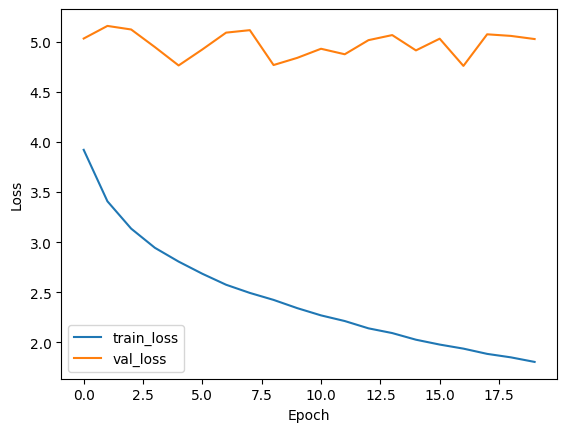

In [156]:
plt.plot(training_epoch_loss, label='train_loss')
plt.plot(validation_epoch_loss,label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show